In [1]:
import os
import glob
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import os, sys
import re
import pickle
import vector
import mplhep as hep
import math
from tabulate import tabulate
from collections import defaultdict

vector.register_awkward()

# parameters for matplotlib styling
plt.style.use(hep.style.CMS)

matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams.update({'font.size': 20})
plt.rcParams['figure.facecolor'] = 'white'

In [7]:
# parameters
unblind = False                               # don't show D_obs for SUEP
input_label = 'noPtCut'
output_label = 'outputs/noJetId'
file_ext = '.pdf'
combine_MC = True                           # is all MC QCD in one file or does it need to be combined
combine_data = True                         # is all data QCD in one file or does it need to be combined
selections = ['ch']
plotDir = os.getcwd()
datasets = os.listdir(plotDir+'/outputs/')
infile_names = [plotDir+'/outputs/'+dataset for dataset in datasets]

Some useful functions used throughout the notebook.
`FIXME`: move these in a utils.py script? Add descriptions?

In [50]:
default_colors = {
    'QCD': 'midnightblue',
    'SUEP-m1000-darkPho': 'red',
    'SUEP-m1000-darkPhoHad': 'red',
    'SUEP-m1000-generic': 'red',
    'SUEP-m750-darkPho': 'orange',
    'SUEP-m750-darkPhoHad': 'orange',
    'SUEP-m750-generic': 'orange',
    'SUEP-m400-darkPho': 'green',
    'SUEP-m400-darkPhoHad': 'green',
    'SUEP-m400-generic': 'green',
    'SUEP-m125-darkPho': 'cyan',
    'SUEP-m125-darkPhoHad': 'cyan',
    'SUEP-m125-generic': 'cyan',
        
}

# function to load files from pickle
def openpkl(infile_name):
    plots={}
    with (open(infile_name, "rb")) as openfile:
        while True:
            try:
                plots.update(pickle.load(openfile))
            except EOFError:
                break
    return plots

def plot1d(h, ax, label, rebin=-1, color='default', lw=1):
    
    if color == 'default': color = default_colors[label]
    if label == 'QCD' and lw==1: lw=3
    
    y, x = h.to_numpy()
    e = np.sqrt(h.variances())
    x = x[:-1]
    if rebin!=-1: x, y, e = combine_bins(x, y, e, n=rebin)
    
    #ax.step(x[:-1],values, label=label, color=color, lw=lw)
    ax.errorbar(x, y, yerr=e, label=label, lw=lw, color=color, fmt="", drawstyle='steps-mid')
    ax.set_xlabel(h.axes[0].label)
    ax.set_ylabel("Events")
    
def plot1d_stacked(hlist, ax, labels, rebin=-1, color='midnightblue', lw=1):
    
    cmap = plt.cm.rainbow(np.linspace(0, 1, len(labels)))

    ylist, elist = [], []
    for l, h, c in zip(labels, hlist, cmap): 
        y, x = h.to_numpy()
        e = np.sqrt(h.variances())
        x = x[:-1]
        if rebin!=-1: x, y, e = combine_bins(x, y, e, n=rebin)

        if len(ylist) > 0: y = y + ylist[len(ylist)-1]
        ylist.append(y)
    
        #ax.step(x[:-1],values, label=label, color=color, lw=lw)
        ax.errorbar(x, y, yerr=e, label=l, lw=lw, color=c, fmt="", drawstyle='steps-mid')
    ax.set_xlabel(hlist[0].axes[0].label)
    ax.set_ylabel("Events")
    
def plot2d(h, ax, log=False):
    w, x, y = h.to_numpy()
    if log: mesh = ax.pcolormesh(x, y, w.T, cmap="RdYlBu", norm=matplotlib.colors.LogNorm())
    else: mesh = ax.pcolormesh(x, y, w.T, cmap="RdYlBu")
    ax.set_xlabel(h.axes[0].label)
    ax.set_ylabel(h.axes[1].label)
    fig.colorbar(mesh)
    
def plot_ratio(h1, h2, plot_label, label1, label2, lumi1=1, lumi2=1, xlim='default', log=True):

    #Set up variables for the stacked histogram
    plt.figure(figsize=(12,10))
    plt.gcf().subplots_adjust(bottom=0.15, left=0.17)
    ax1 = plt.subplot2grid((4,1), (0,0),rowspan=2)

    y1, x1 = h1.to_numpy()
    y1 = y1*lumi1
    y1_errs = np.sqrt(h1.variances())*lumi1
    ax1.step(x1[:-1], y1, color='maroon',label=label1, where='mid')
    ax1.errorbar(x1[:-1], y1, yerr=y1_errs, color="maroon".upper(), fmt="", drawstyle='steps-mid')

    y2, x2 = h2.to_numpy()
    y2 = y2*lumi2
    y2_errs = np.sqrt(h2.variances())*lumi2
    ax1.step(x2[:-1], y2, color='blue',label=label2, where= 'mid')
    ax1.errorbar(x2[:-1], y2, yerr=y2_errs, color="blue".upper(), fmt="", drawstyle='steps-mid')
    
    #Set parameters that will be used to make the plots prettier
    if log: ax1.set_yscale("log")
    ymax = 1e7
    ax1.set_ylim([1e0, ymax])
    if 'A_' in plot_label or 'C_' in plot_label:
        xmin = 0.2
        xmax = 0.5
        ax1.set_xlim([xmin,xmax])
    elif 'B_' in plot_label or 'D_' in plot_label:
        xmin = 0.5
        xmax = 1.0
        ax1.set_xlim([xmin,xmax])
    elif type(xlim) is not str:
        xmin = xlim[0]
        xmax = xlim[1]
        ax1.set_xlim([xmin,xmax])
    else:
        xmin = x1[0]
        xmax = x1[-2]
        ax1.set_xlim([xmin,xmax])
    #max_y = ax1.gca().get_ylim()[1]
    max_y = ymax + ymax*0.2
    max_x = xmax
    min_x = xmin
    x_range = max_x - min_x
    lower_label = min_x - x_range*0.05
    upper_label = max_x - x_range*0.35
    
    #X and Y labels (Do not use the central matplotlob default), text, and legend
    ax1.set_xlabel(plot_label, x=1, ha='right', fontsize=15)
    ax1.set_ylabel("Events/bin", y=1, ha='right')
    cms_txt = ax1.text(
            lower_label, max_y*1.08, u"CMS $\it{preliminary}$",
            fontsize=16, fontweight='bold',
    )

    lumi_txt = ax1.text(
            upper_label, max_y*1.08, r"%.1f fb$^{-1}$ (13 TeV)" % lumi,
            fontsize=14, 
    )
    ax1.legend()

    ax2 = plt.subplot2grid((4,1), (2,0),sharex=ax1)
    plt.setp(ax1.get_xticklabels(), visible=False)
    
    # calculate the upper and lower errors
    # suppress errors where the denonminator is 0
    y1 = np.where(y1>0, y1, -1)
    yerrors_up = np.where(y1>0, y2/y1 - (y2-y2_errs)/(y1+y1_errs), np.nan)
    yerrors_low = np.where(y1>0, (y2+y2_errs)/(y1-y1_errs) - y2/y1, np.nan)
    yerrors = [yerrors_up, yerrors_low]

    ax2.errorbar(x1[:-1],np.where((y2>0) & (y1>0),y2/y1,1),yerr=yerrors, color="black", fmt="", drawstyle='steps-mid')
    ax2.axhline(1, ls="--")
    ax2.set_ylim(0.5,1.5)
    ax2.set_xlabel(plot_label, fontsize=15)
    
def find_nth(string, substring, n):
    if (n == 1):
        return string.find(substring)
    else:
        return string.find(substring, find_nth(string, substring, n - 1) + 1)
    
def combine_bins(x, y, e, n=4):
    old_e = e
    old_y = y
    old_x = x
    
    y = []
    x = []
    e = []
   
    for j in list(range(0,len(old_y), n)):
        
        y.append(np.sum(old_y[j:j+n]))
        x.append(np.sum(old_x[j:j+n])/n)
        e.append(np.sqrt(np.sum(old_e[j:j+n]**2)))
        
    return x, y, e

def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
def D_expect(plots, selection):
    sizeC = plots['C_' + selection].sum()
    sizeA = plots['A_' + selection].sum()
    Bhist = plots['B_' + selection]
    if sizeA.value > 0:
        D_exp = Bhist * sizeC.value / sizeA.value
    else: #Cannot properly predict D without any events in A
        D_exp = Bhist * 0.0
    return D_exp

The `plots` dictionary is used to store all the plots imported from the pickle files. Dimensions: (real or MC) x (plot label) <br>
The `data` nested dictionary stores the number of events and variances in each region for real data and MC data when the plots are made, and is used to make the comparison table. Dimensions: (real or MC) x (plot label) x (value or error on the value)

In [4]:
# dimensions: (real or MC) x (plot label) x (value or error on the value)
stats = nested_dict(4,float)

# dimensions: (real or MC) x (plot label)
plots = {}

# load file(s)
for infile_name in infile_names:
    if not os.path.isfile(infile_name): print("WARNING:",infile_name,"doesn't exist")
    elif input_label not in infile_name: continue
    elif ".pkl" not in infile_name: continue
    else:
        print("Loading",infile_name)
        
        if 'QCD_Pt' in infile_name and combine_MC: sample = 'QCD_MC'
        elif 'Jet' in infile_name and combine_data: sample = 'data'
        elif 'SUEP' in infile_name: sample = infile_name.split('/')[-1].split('+')[0]
        else: sample = infile_name.split('/')[-1].split('.pkl')[0]
        
        if sample not in list(plots.keys()): 
            plots[sample] = openpkl(infile_name)
        else:
            plotsToAdd = openpkl(infile_name) 
            for plot in list(plotsToAdd.keys()):
                plots[sample][plot]  = plots[sample][plot] + plotsToAdd[plot]
                


for selection in selections:
    if combine_MC:
        plots['QCD_MC']['D_exp_' + selection] = D_expect(plots['QCD_MC'],selection)
    if combine_data:
        plots['data']['D_exp_' + selection] = D_expect(plots['data'],selection)

Loading /home/submit/lavezzo/SUEP/SUEPCoffea_dask/plotting/outputs/JetHT+Run2018B-UL2018_MiniAODv2-v1+MINIAOD_noPtCut.pkl
Loading /home/submit/lavezzo/SUEP/SUEPCoffea_dask/plotting/outputs/JetHT+Run2018C-UL2018_MiniAODv2-v1+MINIAOD_noPtCut.pkl
Loading /home/submit/lavezzo/SUEP/SUEPCoffea_dask/plotting/outputs/JetHT+Run2018A-UL2018_MiniAODv2-v1+MINIAOD_noPtCut.pkl
Loading /home/submit/lavezzo/SUEP/SUEPCoffea_dask/plotting/outputs/QCD_Pt_2400to3200_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_noPtCut.pkl
Loading /home/submit/lavezzo/SUEP/SUEPCoffea_dask/plotting/outputs/QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_noPtCut.pkl
Loading /home/submit/lavezzo/SUEP/SUEPCoffea_dask/plotting/outputs/SUEP-m125-darkPho+RunIIAutumn18-private+MINIAODSIM_noPtCut.pkl
Loading /home/submit/lavezzo/SUEP/SUEPCoffea_dask/plotting/outputs/QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISumm

## ABCD Plots
Make ABCD plots for the 4 regions.<br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`save`: _bool_, whether to atuomatically save the plots.<br>
`lumi`: _float_, scales MC data.<br>

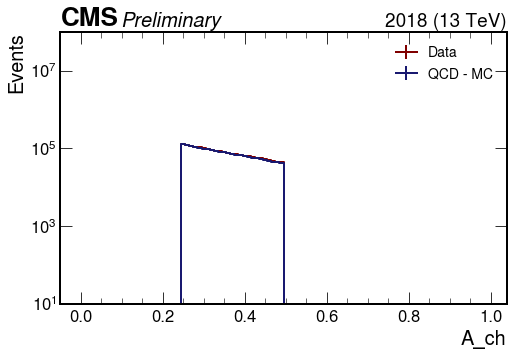

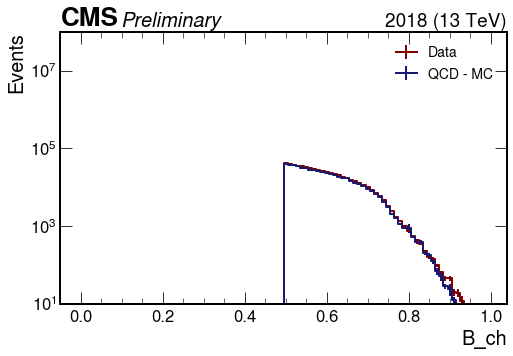

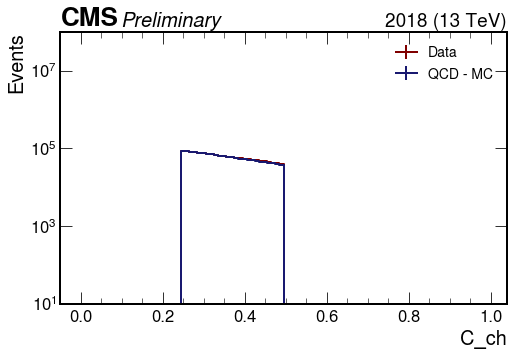

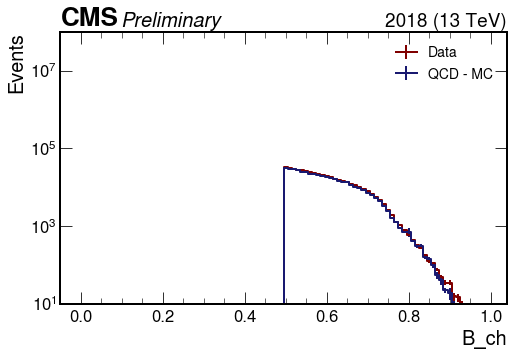

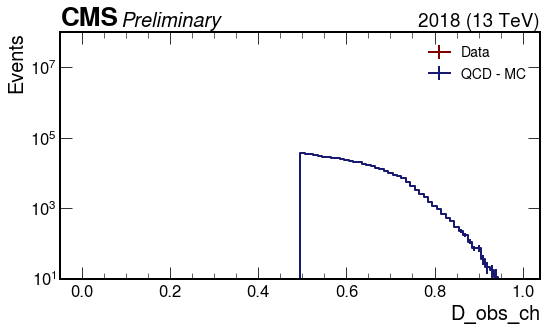

In [5]:
### Make ABCD plots and table based on selection (e.g. 'ch', 'mult')
selection = 'ch'
save = False
lumi = 61000

for plot_label in ['A','B','C','D_exp', 'D_obs']:
    
    plot_label += '_'+selection
            
    # define figure, axis on which to plot QCD and SUEP
    fig, ax = plt.subplots(figsize=(8,5))
    hep.cms.label("Preliminary", data=True, year=2018)

    # QCD hist for ABCD region
    hdata = plots['data'][plot_label]
    hQCD_MC = plots['QCD_MC'][plot_label] * lumi
    
    # plot QCD, sum values and errs
    plot1d(hdata, ax, 'Data', color='maroon', lw=2)
    plot1d(hQCD_MC, ax, 'QCD - MC', color='midnightblue', lw=2)
    
    # fill these up for the table
    stats['data'][plot_label]["value"] = np.sum(hdata.values())
    stats['data'][plot_label]["err"] = np.sum(np.sqrt(hdata.variances()))
    stats['QCD_MC'][plot_label]["value"] = np.sum(hQCD_MC.values())
    stats['QCD_MC'][plot_label]["err"] = np.sum(np.sqrt(hQCD_MC.variances()))
    
    ax.set_ylim(1e1,1e8)
    ax.set_yscale('log')
    ax.legend(loc='best', fontsize=14, framealpha=1, facecolor='white', shadow=True)
    
    if save: fig.savefig(output_label + "_" + plot_label + file_ext, bbox_inches='tight')

fig.tight_layout()
fig.show()

## Closure Plots
Make closure plots for the 4 regions or other variables.<br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`save`: _bool_, whether to atuomatically save the plots.<br>
`lumi`: _float_, scales MC data.<br>

/tmp/ipykernel_2173977/702701912.py:139: RuntimeWarning: invalid value encountered in true_divide
  yerrors_low = np.where(y1>0, (y2+y2_errs)/(y1-y1_errs) - y2/y1, np.nan)


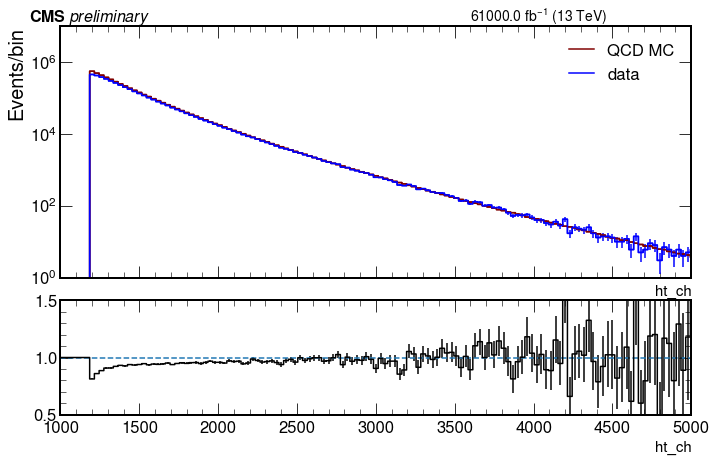

In [53]:
### Make ABCD plots and table based on selection (e.g. 'ch', 'mult')
selection = 'ch'
save = True
lumi = 61000
#plot_labels = ['A','B','C','D_exp', 'SUEP_pt']
plot_labels = ['ht']

for plot_label in plot_labels:
    plot_label += "_" + selection
        
    hQCD_MC = plots['QCD_MC'][plot_label]
    hdata = plots['data'][plot_label]
    
    plot_ratio(hQCD_MC, hdata, plot_label, 'QCD MC', 'data', lumi, 1, xlim=[1000,5000], log=True)
        
    if save: plt.savefig(output_label + "_" + plot_label+ "_closure_"+selection+file_ext)

## ABCD Independent Variables Check
1D slices of 2D plots, usually used to check the independence of the ABCD method's two variables on the QCD sample. This won't work if QCD has been binned by pt. <br>
Parameters:<br>
`plot_label`:_str_, which plot to analyze.<br>
`save`: _bool_, whether to atuomatically save the plots.<br>
`slice_label`: _str_, variable being sliced, used in the plot legend.<br>
`slices`: _list of lists of floats_, bins of values to be sliced. e.g. for equal slices use np.linspace(start, end, number of bins), if not can specify as [[0,10],[20,40],[40,50],...].

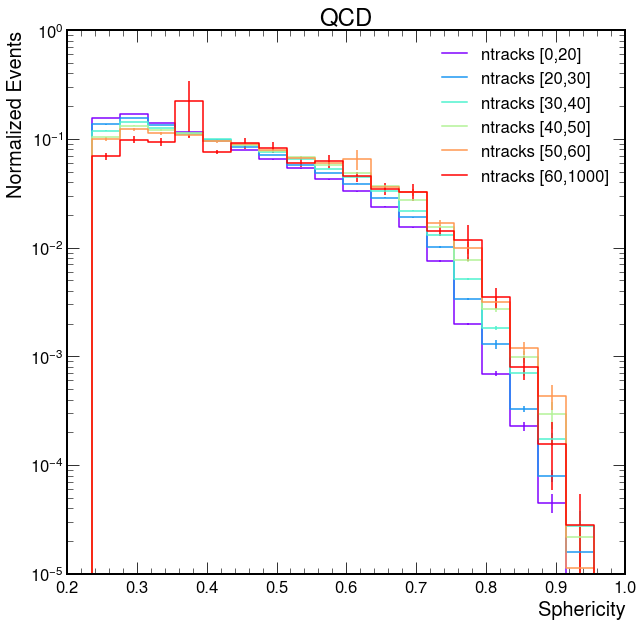

In [13]:
# parameters
plot_label = '2D_spher_nconst_ch' 
save = True
slice_label = 'ntracks'            
slices = [[0,20],[20,30],[30,40],[40,50],[50,60],[60,1000]]

#  color map
cmap = plt.cm.rainbow(np.linspace(0, 1, len(slices)))

# get the histogram
h = plots['QCD_MC'][plot_label]
w, x, y =h.to_numpy()
errs = h.variances()
x=x[:-1]
y=y[:-1]

# cut below sphericity 0.2
# sphericityCut = (x>=0.2)
# x=x[sphericityCut]
# w=w[sphericityCut,:]
# errs = errs[sphericityCut,:]

for i in range(len(slices)):
    val_lo = slices[i][0]
    val_up = slices[i][1]
    
    x_vals = x
    y_vals = np.sum(w[:,(y>val_lo) & (y<=val_up)],axis=1)
    norm = np.sum(y_vals) 
    y_vals = y_vals / norm
    e_vals = np.sqrt(np.sum(errs[:,(y>val_lo) & (y<=val_up)],axis=1))/norm
    
    ### FIXME: could be made a parameter
    # where you can define which slices you want to rebin
    if True:
        x_vals, y_vals, e_vals = combine_bins(x_vals, y_vals, e_vals, 4)
        
    plt.errorbar(x_vals, y_vals, e_vals, linestyle='', color=cmap[i])
    plt.step(x_vals, y_vals, label=slice_label+" [{0},{1}]".format(val_lo, val_up), where='mid', color=cmap[i])

plt.legend()
plt.title("QCD")
plt.xlim(0.2,1.0)
plt.ylim(1e-5,1)
plt.yscale('log')
plt.ylabel("Normalized Events")
plt.xlabel("Sphericity")
if save: plt.savefig(output_label + "_" + plot_label + "_1D_slices"+file_ext,  bbox_inches='tight')

## Binned QCD Plots
Make plots with the QCD separated by bins. This won't work if QCD has been marged. <br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`save`: _bool_, whether to atuomatically save the plots.<br>
`lumi`: _float_, scales MC data.<br>
`plot_labels`: _list_, which plots you want to make.

IndexError: list index out of range

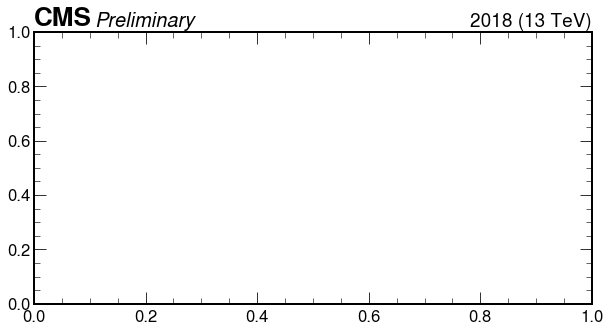

In [10]:
selection = 'ch'
save = True
lumi = 61000
plot_labels = ['pt']

for plot_label in plot_labels:
    
    plot_label = 'SUEP_' + selection + '_' + plot_label
    
    # define figure, axis on which to plot QCD and SUEP
    fig, ax = plt.subplots(figsize=(10,5))
    hep.cms.label("Preliminary", data=True, year=2018)

    # get hists
    hlist, labels = [], []
    for key in plots.keys():
        if 'QCD_Pt' in key:
            hlist.append(plots[key][plot_label] * lumi)
            key = key.split('_Tune')[0]
            labels.append(key)
            
    # not sure why, but they need to be color coded appropriately
    vals = []
    for key in labels:
        keyslice = key.split("Pt_")[1]
        keyslice = keyslice.split("to")[0]
        val = int(keyslice)
        vals.append(val)
    hlist_sorted, labels_sorted = [], []
    for arg in np.argsort(vals)[::-1]:
        hlist_sorted.append(hlist[arg])
        labels_sorted.append(labels[arg])
        
    # plot QCD
    plot1d_stacked(hlist_sorted, ax, labels_sorted, lw=1)

    # plotting parameters
    ax.set_ylim(1e4,1e9)
    ax.set_xlim(100,400)
    ax.set_yscale('log')
    ax.legend(fontsize=10, framealpha=1, facecolor='white', shadow=True, bbox_to_anchor=(1.04,1), loc="upper left")
    
    if save: fig.savefig(output_label + "_" + plot_label + file_ext, bbox_inches='tight')
    
fig.tight_layout()
fig.show()

## More Plots
Make more plots.<br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`save`: _bool_, whether to atuomatically save the plots.<br>
`lumi`: _float_, scales MC data.<br>
`SUEPtype`: _str_, which type of SUEP to show (e.g. 'generic', 'darkPho', darkPhoHad').<bar>
`plot_labels`: _list_, which plots you want to make.

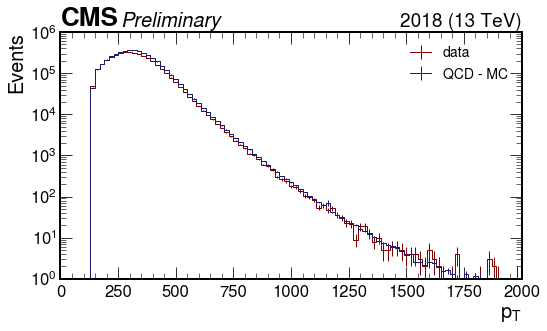

In [10]:
selection = 'ch'
save = False
lumi = 61000
SUEPtype = 'darkPho'
plot_labels = ['SUEP_pt']

for plot_label in plot_labels:
    
    #plot_label = 'SUEP_' + selection + '_' + plot_label
    plot_label = plot_label + '_' + selection
    
    # define figure, axis on which to plot QCD and SUEP
    fig, ax = plt.subplots(figsize=(8,5))
    hep.cms.label("Preliminary", data=True, year=2018)

    # get hists
    hdata = plots['data'][plot_label]
    hQCD_MC = plots['QCD_MC'][plot_label] * lumi
    hSUEP125 = plots['SUEP-m125-'+SUEPtype][plot_label] * lumi
    hSUEP400 = plots['SUEP-m400-'+SUEPtype][plot_label] * lumi
    hSUEP750 = plots['SUEP-m750-'+SUEPtype][plot_label] * lumi
    hSUEP1000 = plots['SUEP-m1000-'+SUEPtype][plot_label] * lumi
    
    # plot QCD, sum values and errs
    plot1d(hdata, ax, 'data', color='maroon', lw=1)
    plot1d(hQCD_MC, ax, 'QCD - MC', color='midnightblue', lw=1)
    # plot1d(hSUEP125, ax, 'SUEP125', color='green', lw=1)
    # plot1d(hSUEP400, ax, 'SUEP400', color='yellow', lw=1)
    # plot1d(hSUEP750, ax, 'SUEP750', color='magenta', lw=1)
    # plot1d(hSUEP1000, ax, 'SUEP1000', color='cyan', lw=1)
    
    # plotting parameters
    ax.set_ylim(1e0,1e6)
    ax.set_xlim(0,2000)
    ax.set_yscale('log')
    ax.legend(loc='best', fontsize=14, framealpha=1, facecolor='white', shadow=True)
    
    if save: fig.savefig(output_label + "_" + plot_label + file_ext, bbox_inches='tight')
    
fig.tight_layout()
fig.show()

## Make 2D plots.
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`save`: _bool_, whether to atuomatically save the plots.<br>
`lumi`: _float_, scales MC data.<br>
`plot_labels`: _list_, which plots you want to make.

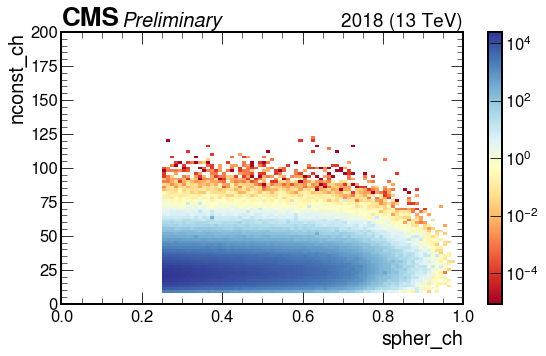

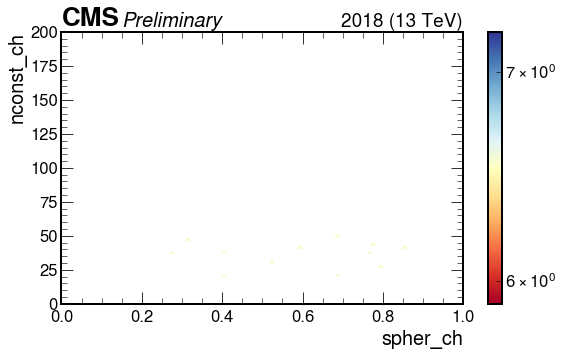

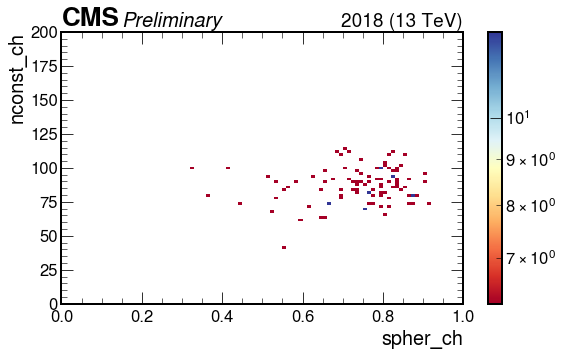

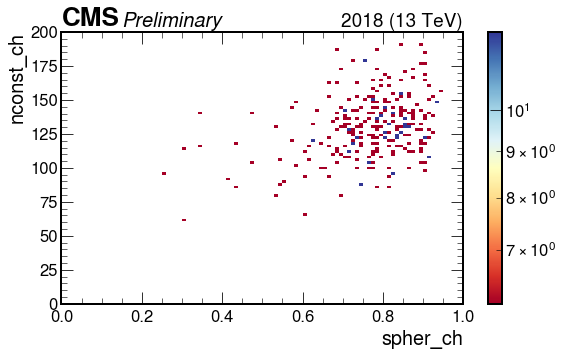

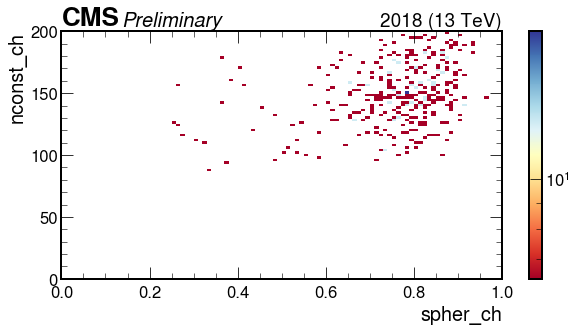

In [54]:
selection = 'ch'
SUEPType = 'darkPho'
save = True
lumi = 61000
plot_labels = ['2D_spher_nconst']

for plot_label in plot_labels:
    plot_label = plot_label + '_' + selection
    
    for sample in ['QCD_MC', 
                'SUEP-m125-'+SUEPtype, 'SUEP-m400-'+SUEPtype,
                'SUEP-m750-'+SUEPtype, 'SUEP-m1000-'+SUEPtype]:
    
        # define figure, axis on which to plot QCD and SUEP
        fig, ax = plt.subplots(figsize=(9,5))
        hep.cms.label("Preliminary", data=True, year=2018)

        # get hists
        h = plots[sample][plot_label] * lumi

        # plot QCD, sum values and errs
        plot2d(h, ax, log=True)

        # plotting parameters
        #ax.set_ylim(1e1,1e8)
        #ax.set_xlim(0,10)

        if save: fig.savefig(output_label + "_" + sample + "_" + plot_label + file_ext, bbox_inches='tight')

    fig.tight_layout()
    fig.show()

## Table

Make comparison table by running next 3 cells. The output is meant to be in Latex format.

In [40]:
table = []
for i in range(len(list(stats.keys()))):
    label = list(stats.keys())[i]
    line = []
    line.append(label)
    
    for r in ['A_'+selection,'B_'+selection,'C_'+selection,'D_exp_'+selection,'D_obs_'+selection]:
        if 'QCD_MC' in label:
            line.append("{:0.0f} ".format(stats[label][r]['value']) + r'$\pm$' + " {:0.0f}".format(stats[label][r]['err']))
        else:
            line.append("{:0.2f} ".format(stats[label][r]['value']) + r'$\pm$' + " {:0.2f}".format(stats[label][r]['err']))
        
    if 'QCD_MC' in label:
        line.append(round((stats[label]['D_exp_'+selection]['value']-stats[label]['D_obs_'+selection]['value'])/stats[label]['D_exp_'+selection]['value'],2))
        line.append(0)
    else:
        line.append(0)
        line.append(stats[label]['D_obs_'+selection]['value']/math.sqrt(stats[label]['D_obs_'+selection]['value']+stats[label]['D_exp_'+selection]['value']+stats[label]['D_obs_'+selection]['err']+stats['QCD_MC']['D_exp_'+selection]['err']))
    table.append(line)                                                         

In [41]:
t = tabulate(table,tablefmt ='latex',
               headers=['Process', 'A', 'B', 'C', 'D_{exp}', 'D_{obs}', 'D_{exp}-D_{obs}/D_{exp}', 'S/$\sqrt(S+B+\sigma_{S}+\sigma_{B}$)'])
with open('table.txt', 'w') as f:
    f.write(t)
t

'\\begin{tabular}{llllllrr}\n\\hline\n Process   & A                          & B                         & C                         & D\\_\\{exp\\}                  & D\\_\\{obs\\}                &   D\\_\\{exp\\}-D\\_\\{obs\\}/D\\_\\{exp\\} &   S/\\$\\textbackslash{}sqrt(S+B+\\textbackslash{}sigma\\_\\{S\\}+\\textbackslash{}sigma\\_\\{B\\}\\$) \\\\\n\\hline\n data      & 19772835.00 \\$\\textbackslash{}pm\\$ 21997.23 & 6171263.00 \\$\\textbackslash{}pm\\$ 13280.27 & 8188792.00 \\$\\textbackslash{}pm\\$ 14239.75 & 2555788.74 \\$\\textbackslash{}pm\\$ 5499.94 & 0.00 \\$\\textbackslash{}pm\\$ 0.00        &                      0    &                                      0 \\\\\n QCD\\_MC    & 159395390 \\$\\textbackslash{}pm\\$ 52678503   & 30102297 \\$\\textbackslash{}pm\\$ 5545308    & 22090204 \\$\\textbackslash{}pm\\$ 340243     & 4171801 \\$\\textbackslash{}pm\\$ 768510     & 15089007 \\$\\textbackslash{}pm\\$ 5412898 &                     -2.62 &                                  

In [42]:
def convert2LatexString(s):
    r = r'(\^\{\})'; s = re.sub(r, "^", s)
    s = re.sub(r'\\([\$\_\{\}\^])', r'\1', s)
    s = re.sub(r'(\\textbackslash{})', r'\\', s)
    return s

t = convert2LatexString(t)
with open('table.txt', 'w') as f:
    f.write(t)
t

'\\begin{tabular}{llllllrr}\n\\hline\n Process   & A                          & B                         & C                         & D_{exp}                  & D_{obs}                &   D_{exp}-D_{obs}/D_{exp} &   S/$\\sqrt(S+B+\\sigma_{S}+\\sigma_{B}$) \\\\\n\\hline\n data      & 19772835.00 $\\pm$ 21997.23 & 6171263.00 $\\pm$ 13280.27 & 8188792.00 $\\pm$ 14239.75 & 2555788.74 $\\pm$ 5499.94 & 0.00 $\\pm$ 0.00        &                      0    &                                      0 \\\\\n QCD_MC    & 159395390 $\\pm$ 52678503   & 30102297 $\\pm$ 5545308    & 22090204 $\\pm$ 340243     & 4171801 $\\pm$ 768510     & 15089007 $\\pm$ 5412898 &                     -2.62 &                                      0 \\\\\n\\hline\n\\end{tabular}'